# Sentiment Analysis using Support Vector Machine
---------------------------------------------------------------------------------------

Code consists of six parts:
1. importing modules
2. data preprocessing
3. vectorizer model
4. SVM model
5. model evaluation
6. sentiment prediction

## 1. Importing Modules

In [ ]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import time

#Text Preprocessing for aspect extraction
import string
import emoji
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
# spacy for lemmatization
import spacy


# for building models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# to save models 
import pickle

In [ ]:
# The first step will be importing modules
data = pd.read_csv('IMDB Dataset.csv')

In [3]:
data['label'] = data['sentiment'].replace(['positive', 'negative'],['1', '0'])

In [4]:
data

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


The dataset has 3 columns, 'review', 'sentiment', 'label'

In [5]:
# check the number of postive and negative reviews
data.label.value_counts()

label
1    25000
0    25000
Name: count, dtype: int64

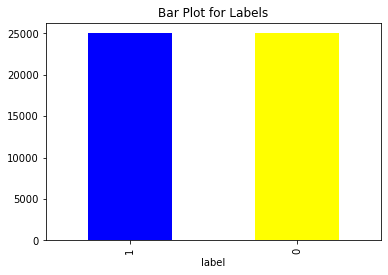

In [6]:
# visualise the distribution of labels in the dataset in bar plots
count_Class = pd.value_counts(data.label, sort=True)
count_Class.plot(kind = 'bar', color = ['blue', 'yellow'])
plt.title("Bar Plot for Labels")
plt.show()

In [7]:
# save data with labels into csv
data.to_csv('C:/Users/jingy/OneDrive/Desktop/xmum_mjy/year 3 sem II/NLP/assignment/part1/IMDB_Dataset_label.csv')

# 2. Data Preprocessing

The purpose of data preprocessing is to prepare data for building SVM models. Data preprocessing improves accuracy and reliability of models by removing inconsistent or missing data.

### 2.1 Text Preprocessing
remove noises in the data, numbers, hashtags, punctuations, lowercase all characters, demoji, remove stopwords and lemmatize texts

In [8]:
# spacy for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nltk for removing stop words
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    #1. Generating the list of words in the tweet (hastags and other punctuations removed)
    text_blob = TextBlob(text)
    text = ' '.join(text_blob.words)
    #2. clean the number 
    text = re.sub(r'[0-9]', '', text)
    #3. lower the text
    text = text.lower()
    #4. conver the emoji to text form
    text = emoji.demojize(text)
    #5. remove punctuation 
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    #6. tokenize the text
    text = word_tokenize(text)
    #7. remove empty token
    text = [t for t in text if len(t) > 0]
    #8. remove non-alphabetical token
    text = [t for t in text if t.isalpha()]
    #9. replace the negation token
    replacer  = AntonymReplacer()
    text = replacer.replace_negations(text)
    #10. remove the stopwords
    text = [i for i in text if i not in stopwords]
    #11. lemmatize the text
    text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return " ".join(text)


def lemmatization(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(" ".join(sent)) 
    texts_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return texts_out

class AntonymReplacer(object):
    def replace(self, word, pos=None):
        antonyms = set()

        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name())

        if len(antonyms) == 1:
            return antonyms.pop()
        else:
            return None

    def replace_negations(self, sent):
        i, l = 0, len(sent)
        words = []

        while i < l:
            word = sent[i]

            if word == 'not' and i+1 < l:
                ant = self.replace(sent[i+1])

                if ant:
                    words.append(ant)
                    i += 2
                    continue

            words.append(word)
            i += 1

        return words

In [9]:
%%time
# preprocess data
data['clean'] = data['review'].apply(lambda rev : preprocess(rev))

Wall time: 8min 42s


In [10]:
# check the difference before and after data preprocessing

pd.set_option("max_colwidth", None)
data.review[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [11]:
# data after preprocessing
data.clean[1]

'wonderful little production br br film technique unassume oldtimebbc fashion give comforting sometimes discomforte sense realism entire piece actor extremely well choose get polari voice pat truly see seamless editing guide reference diary entry well worth watch terrificly write perform piece masterful production great master comedy life br really come home little thing fantasy guard rather use traditional dream technique remain solid disappear play knowledge sense particularly scene concern set particularly flat halliwell mural decorate surface terribly well do'

We can see that, after text preprocessing, the number of words have been reduced, punctuations are removed, and all words are lowercased.

# Part 1

# 3. Vectorizer Model 1 (Feature Extraction using TF-IDF)

In SVM, data must first be represented in vectors as required by SVM. Vectorizer is the process of transforming data into vectors.

In [1]:
vec = TfidfVectorizer(
    min_df=2,          # discard words that are appearing in less than 2 documents
    max_df=0.9,        # discard words that appear in more than 90% of the documents
    sublinear_tf=True, # use sublinear weightlifting
    use_idf=True       # enable IDF, the most important parameter for TF-IDF
)

NameError: name 'TfidfVectorizer' is not defined

In [42]:
#save vectorizer
vectorizer_file = 'tf-idf_vectorizer.sav';
pickle.dump(vec, open(vectorizer_file, 'wb'))

In [13]:
# fit preprocess data into TF-IDF Model to train the model
%%time
tfidf_model = vec.fit(data['clean'])
tfidf_vec = vec.transform(data['clean'])

Wall time: 5.28 s


In [15]:
# split the dataset into 80, 20% 
from sklearn.model_selection import train_test_split
SEED = 4000
    
X_train, X_test, y_train, y_test = train_test_split(tfidf_vec, data.label, test_size=0.2, random_state=SEED)

In [16]:
print(X_train.shape)
print(y_train.shape)

(40000, 41673)
(40000,)


## 4. Building SVM Model using TF-IDF

In [46]:
%%time
# fit the data after tf-idf vectorization into svm model
tfidf_svm = SVC(kernel='linear')
tfidf_svm.fit(X_train, y_train)

Wall time: 13min 23s


SVC(kernel='linear')

In [47]:
# save the model to disk
filename1 = 'svm_tf-idf_model.sav'
pickle.dump(svm, open(filename1, 'wb'))

In [48]:
%%time
predictions = tfidf_svm.predict(X_test)

Wall time: 1min 31s


# 5. Model Evaluation 

Ways to evaluate the model
1. Classification Report
2. Confusion Matrix
3. Accuracy

In [49]:
print("---------------------------------------------------")
print("Using TF-IDF : \n")
report = classification_report(predictions, y_test)
print("Result of SVM \n",report)

---------------------------------------------------
Using TF-IDF : 

Result of SVM 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      4911
           1       0.90      0.88      0.89      5089

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Text(0.5, 15.0, 'Predicted label')

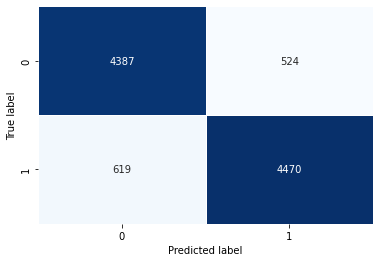

In [50]:
# confusion matrix for tf-idf
tfidf_conf = confusion_matrix(predictions, y_test)
sns.heatmap(tfidf_conf, annot=True, fmt='d', linewidths=.5, cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [51]:
accuracy = accuracy_score(predictions, y_test)
print("Accuracy score for SVM using TF-IDF\n", accuracy)

Accuracy score for SVM using TF-IDF
 0.8857


Number of correctly predicted sentiments is 4387 + 4470, and the total number of sentiments predicted is 10000.

The accuracy is number of correctly predicted sentiments / total number of sentiments predicted,
8857/10000 = 0.8857

# 6. Predicting Sentiment using TF-IDF

To test out the sentiment analysis model, we use it to predict sentiment of self-constructed sentences

In [58]:
# preprcoess and predict review
def tfidf_predict(review):
    preprocess_review = preprocess(review)
        # print preprocessed review
    print("After preprocessing :")
    print(preprocess_review)
    
    review_vector = vec.transform([review])
    pred = tfidf_svm.predict(review_vector)
    
    if pred == str(1):
        return 'positive statement'
    else:
        return 'negative statement'

In [59]:
review = "I am very happy with this product, it has many benefits"

print(tfidf_predict(review))

After preprocessing :
happy product many benefit
positive statement


In [60]:
review2 = "I received defective piece display is not working properly"

print(tfidf_predict(review2))

After preprocessing :
receive defective piece display work properly
negative statement


As we can see, SVM model using TF-IDF is successfully in predicting the sentiment of both reviews.

# Part 2

# 1. Vectorizer Model 2 (Feature Extraction using CountVectorizer)

In [26]:
def custom_tokenizer(text):
    # create a space between special characters 
    text=re.sub("(\\W)"," \\1 ",text)
    # split based on whitespace
    return re.split("\\s+",text)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# use own custom_tokenizer and preprocessor 
vectorizer = CountVectorizer(min_df = 2, max_df = 0.9,tokenizer=custom_tokenizer, preprocessor=preprocess)
vectorizer.fit(data['review'])
# count vectorizes the text
cv_vec = vectorizer.transform(data['review'])

C:\Users\jingy\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
#save vectorizer
vectorizer_file2 = 'cv_ectorizer.sav';
pickle.dump(cv_vec, open(vectorizer_file2, 'wb'))

In [52]:
# Printing the identified Unique words along with their indices
print("Total length of vocabulary", len(vectorizer.vocabulary_))
print("Vocabulary: \n", vectorizer.vocabulary_)

Total length of vocabulary 41696
Vocabulary: 
 {'reviewer': 30238, 'mention': 22447, 'watch': 40310, 'episode': 11673, 'hook': 17072, 'right': 30382, 'exactly': 11990, 'happen': 16057, 'first': 13185, 'thing': 36664, 'strike': 35059, 'brutality': 4563, 'unflinche': 38699, 'scene': 31455, 'violence': 39897, 'set': 32314, 'word': 41158, 'go': 14958, 'trust': 37795, 'show': 32785, 'faint': 12461, 'hearted': 16378, 'timid': 36978, 'pull': 28585, 'punch': 28611, 'regard': 29640, 'drug': 10575, 'sex': 32363, 'hardcore': 16091, 'classic': 6263, 'use': 39406, 'call': 4968, 'nickname': 24353, 'give': 14821, 'oswald': 25593, 'maximum': 22109, 'security': 31865, 'state': 34616, 'penitentary': 26622, 'focus': 13502, 'mainly': 21517, 'section': 31857, 'prison': 28138, 'cell': 5526, 'glass': 14861, 'front': 14044, 'face': 12400, 'inward': 18836, 'privacy': 28143, 'high': 16692, 'agenda': 593, 'city': 6192, 'home': 16981, 'many': 21775, 'aryan': 1887, 'italian': 18975, 'irish': 18864, 'scuffle': 3174

In [29]:
# Summarizing the Encoded Texts
print("Encoded Document is:")
print(cv_vec.toarray())

Encoded Document is:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
SEED = 4000

cv_X_train, cv_X_test, cv_y_train, cv_y_test = train_test_split(cv_vec, data.label, test_size=0.2, random_state=SEED)

In [32]:
print(cv_X_train.shape)
print(cv_y_train.shape)

(40000, 41696)
(40000,)


## 2. Building SVM using CountVectorizer

In [33]:
%%time
svm = SVC(kernel='linear')
svm.fit(cv_X_train, cv_y_train)

Wall time: 1h 45min 56s


SVC(kernel='linear')

In [44]:
# save the model to disk
filename2 = 'svm_cv_model.sav'
pickle.dump(svm, open(filename2, 'wb'))

# 3. Model Evaluation

Ways to evaluate the model
1. Classification Report
2. Confusion Matrix
3. Accuracy

In [34]:
cv_predictions = svm.predict(cv_X_test)
print("---------------------------------------------------")
print("Using CountVectorizer : \n")
cv_report = classification_report(cv_predictions, cv_y_test)
print("Result of SVM \n",cv_report)

---------------------------------------------------
Using CountVectorizer : 

Result of SVM 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      4925
           1       0.86      0.85      0.85      5075

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Text(0.5, 15.0, 'Predicted label')

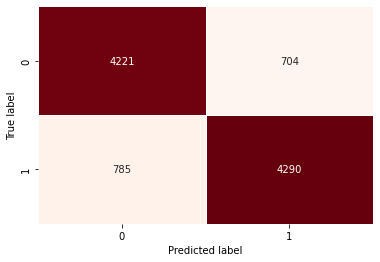

In [35]:
tfidf_conf = confusion_matrix(cv_predictions, cv_y_test)
sns.heatmap(tfidf_conf, annot=True, fmt='d', linewidths=.5, cmap='Reds', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Number of correctly predicted sentiments is 4221 + 4290, and the total number of sentiments predicted is 10000.

The accuracy is number of correctly predicted sentiments / total number of sentiments predicted,
8511/10000 = 0.8511

In [36]:
cv_accuracy = accuracy_score(cv_predictions, cv_y_test)
print("Accuracy score for SVM using CountVectorizer \n", cv_accuracy)

Accuracy score for SVM using CountVectorizer 
 0.8511


# 4. Predicting Sentiment using CountVectorizer

I create a review and use the model to predict its sentiment

In [53]:
# preprcoess and predict review
def cv_predict(review):
    preprocess_review = preprocess(review)
    # print preprocessed review
    print("After preprocessing :")
    print(preprocess_review)
    
    review_vector = vectorizer.transform([review])
    pred = svm.predict(review_vector)
    
    if pred == str(1):
        return 'positive statement'
    else:
        return 'negative statement'

In [54]:
review = "I am very happy with this product, it has many benefits"

print(cv_predict(review))

After preprocessing :
happy product many benefit
positive statement


In [55]:
review2 = "I received defective piece display is not working properly"

print(cv_predict(review2))

After preprocessing :
receive defective piece display work properly
negative statement


As we can see, SVM model is successfully in predicting the sentiment of both reviews.

________________________________________________________________________________________________________________________

# Summary
Two machine learning sentiment analysis models are created using TF-IDF and CountVectorizer. Both achieved respectively high accuracy of 0.8857 and 0.8511.Both models can be said to be a success as it has high training and validation accuracy.